In [ ]:
!pip install -q ortools

In [11]:
import pandas as pd, numpy as np
from ortools.sat.python import cp_model # MILP
#inputs
nodes = pd.read_excel('route_inputs.xlsx', sheet_name='nodes')
paths = pd.read_excel('route_inputs.xlsx', sheet_name='paths')
n_nodes = len(nodes)
n_paths = len(paths)
print('Nodes =====')
print(nodes)
print('Paths =====')
print(paths)

Nodes =====
   node   description
0     1        origin
1     2  middle point
2     3  middle point
3     4  middle point
4     5  middle point
5     6  middle point
6     7   destination
Paths =====
   node_from  node_to  distance
0          1        2       220
1          1        3      1500
2          2        4       650
3          2        5       900
4          4        7       500
5          5        7       400
6          3        6       500
7          6        7       400


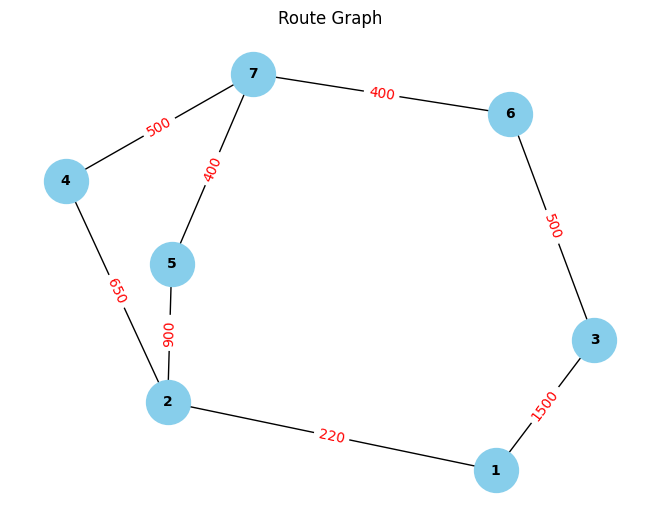

In [62]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
# Create a graph object
G = nx.Graph()

# Add nodes to the graph
for _, node in nodes.iterrows():
    G.add_node(node['node'], label=node['description'])

# Add edges to the graph
for _, path in paths.iterrows():
    G.add_edge(path['node_from'], path['node_to'], weight=path['distance'])

# Draw the graph
pos = nx.spring_layout(G)  # Position nodes using Fruchterman-Reingold force-directed algorithm
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue', font_size=10, font_weight='bold')
edge_labels = {(edge[0], edge[1]): G.edges[edge]['weight'] for edge in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

# Show the graph
plt.title('Route Graph')
plt.show()

In [12]:
x = np.zeros(n_paths).tolist() #it has index of the paths like x[0] for first index i.e. node 1 to 2
x

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [21]:
#model
model = cp_model.CpModel()
for p in paths.index:
    x[p] = model.NewIntVar(0,1,'x[{}]'.format([p])) # adding binary variable to the model

print(x) # each index of x like x[[0]] goes 0 to 1 binary variable hence x[[0]](0..1)
 # x[[0]](0..1) means we are taking about index one where node 1 to 2 distance 220 this x[0] value can be 0 or 1
print(x[0])

[x[[0]](0..1), x[[1]](0..1), x[[2]](0..1), x[[3]](0..1), x[[4]](0..1), x[[5]](0..1), x[[6]](0..1), x[[7]](0..1)]
x[[0]]


In [23]:
#objective function
objFun = sum([x[p] * paths.distance[p] for p in paths.index])
model.Minimize(objFun)
print(objFun) # sum of multiplication of each path and weightage

((((((((220 * x[[0]]) + (1500 * x[[1]])) + (650 * x[[2]])) + (900 * x[[3]])) + (500 * x[[4]])) + (400 * x[[5]])) + (500 * x[[6]])) + (400 * x[[7]]))


In [32]:
#filtering origin and destination node
node_origin = int(nodes.node[nodes.description=='origin'].iloc[0])
node_destination = int(nodes.node[nodes.description=='destination'].iloc[0])
print("========Nodes======= \n",nodes)
print("node_origin",node_origin)
print("node_destination",node_destination)

========Nodes======= 
    node   description
0     1        origin
1     2  middle point
2     3  middle point
3     4  middle point
4     5  middle point
5     6  middle point
6     7   destination
node_origin 1
node_destination 7


In [42]:
print(paths)
# node which are going from first node or origin node
print("===path from origin value===\n",paths[paths.node_from==node_origin]) #node which are going from origin node
print("===path from origin index ==\n", paths.index[paths.node_from==node_origin]) #get the index which are going from origin node
print("-------------------")
print("===path to Destination value===\n",paths[paths.node_to==node_destination]) #node which are going from origin node
print("===path to Destination index ==\n", paths.index[paths.node_to==node_destination]) #get the index which are going from origin node

   node_from  node_to  distance
0          1        2       220
1          1        3      1500
2          2        4       650
3          2        5       900
4          4        7       500
5          5        7       400
6          3        6       500
7          6        7       400
===path from origin value===
    node_from  node_to  distance
0          1        2       220
1          1        3      1500
===path from origin index ==
 Index([0, 1], dtype='int64')
-------------------
===path to Destination value===
    node_from  node_to  distance
4          4        7       500
5          5        7       400
7          6        7       400
===path to Destination index ==
 Index([4, 5, 7], dtype='int64')


In [43]:
#constraint where node to destination node should be 1 and node from origin should be 1
model.Add(sum([x[p] for p in paths.index[paths.node_from==node_origin]]) == 1) # here p is 0 and 1 index where edge from origin node
model.Add(sum([x[p] for p in paths.index[paths.node_to==node_destination]]) == 1) # here p is 4 5 and 7 index where edge to destination node

In [59]:
#constraint sum(x, in) == sum(x, out) sum of edge going to node should be equal to sum of edge going from node
print("all middle point \n",nodes[nodes.description=='middle point']) # all middle point node index
print("all middle point node index\n",nodes.node[nodes.description=='middle point']) # all middle point node index
for node in nodes.node[nodes.description=='middle point']:
    sum_in = sum([x[p] for p in paths.index[paths.node_to==node]])
    sum_out = sum([x[p] for p in paths.index[paths.node_from==node]])
    model.Add(sum_in == sum_out)

all middle point 
    node   description
1     2  middle point
2     3  middle point
3     4  middle point
4     5  middle point
5     6  middle point
all middle point node index
 1    2
2    3
3    4
4    5
5    6
Name: node, dtype: int64


In [61]:
#solve
solver = cp_model.CpSolver()
status = solver.Solve(model)

#print
print('status =', solver.StatusName(status))
print('OF =', solver.ObjectiveValue())

paths['activated'] = 0
for p in paths.index:
    paths.activated[p] = solver.Value(x[p]) # assigning the optimal binary value
print(paths)
# show only activated path
paths[paths.activated==1]

status = OPTIMAL
OF = 1370.0
   node_from  node_to  distance  activated
0          1        2       220          1
1          1        3      1500          0
2          2        4       650          1
3          2        5       900          0
4          4        7       500          1
5          5        7       400          0
6          3        6       500          0
7          6        7       400          0


,node_from,node_to,distance,activated
0,1,2,220,1
2,2,4,650,1
4,4,7,500,1


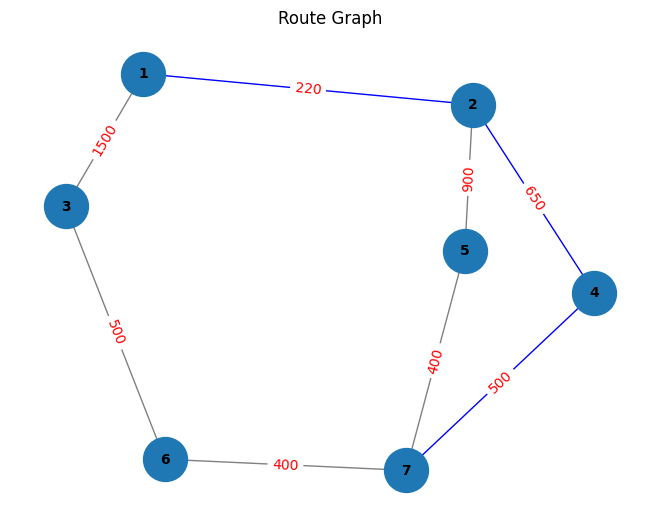

In [67]:
# Finding shortes path in the graph
for _, node in nodes.iterrows():
    G.add_node(node['node'], label=node['description'])

# Add edges to the graph
for _, path in paths.iterrows():
    edge_color = 'blue' if path['activated'] == 1 else 'grey'
    G.add_edge(path['node_from'], path['node_to'], weight=path['distance'], color=edge_color)

# Draw the graph
pos = nx.spring_layout(G)  # Position nodes using Fruchterman-Reingold force-directed algorithm
nx.draw(G, pos, with_labels=True, node_size=1000, font_size=10, font_weight='bold', edge_color=[G[u][v]['color'] for u, v in G.edges])
edge_labels = {(edge[0], edge[1]): G.edges[edge]['weight'] for edge in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

# Show the graph
plt.title('Route Graph')
plt.show()